<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/ESAA_YB_week13_1_markdown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **03 평균 이동**

**평균 이동(Mean Shift)의 개요**

평균 이동(Mean Shift): 중심을 군집의 중심으로 지속적으로 움직이면서 군집화 수행

=> 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동

    <=> K-평균: 중심에 소속된 데이터의 평균 거리 중심 이동

- 데이터의 분포도 이용해 군집 중심점 찾음 - 확률 밀도 함수(probability density function)
- 가장 집중적으로 데이터가 모여있어 확률 밀도 함수가 피크인 점 - KDE(Kernel Density Estimation)
- 특정 데이터를 반경 내 데이터 분포 확률 밀도가 가장 높은 곳으로 이동하기 위해 데이터 거리 값 KDE 함수 값으로 입력한 뒤 그 반환 값을 현재 위치에서 업데이트 하면서 이동하는 방식

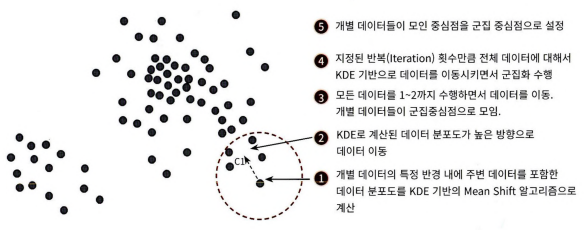

*KDE(Kernel Density Estimation)*: 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적 방법
- 개별 관측 데이터에 커널 함수를 적용한 뒤 적용 값을 모두 더한 후 개별 관측 데이터의 건수로 나눠 확률 밀도 함수로 추정 (대표적: 가우시안 분포 함수)
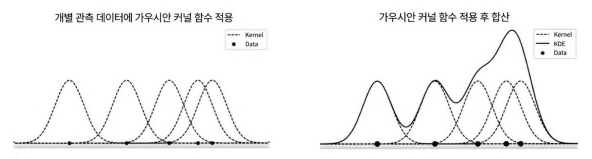


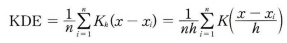 : h = 대역폭(bandwidth)



- h=1.0: 좁고 뾰족한 KDE => 변동성이 큰 방식으로 확률 밀도 함수 추정하므로 과적합(over-fitting)하기 쉬움
- h=10: 과도하게 평활화(smoothing)된 KDE => 지나치게 단순화된 방식으로 확률 밀도 함수를 추정하며 과소적합(under-fitting)하기 쉬움
- KDE 기반 평균 이동(Mean Shift) 군집화에서 매우 중요

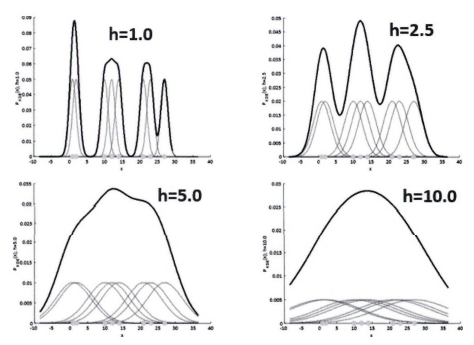

In [ ]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift=MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [ ]:
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [ ]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth, 3))

bandwidth 값: 1.816


In [ ]:
import pandas as pd

clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

# estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


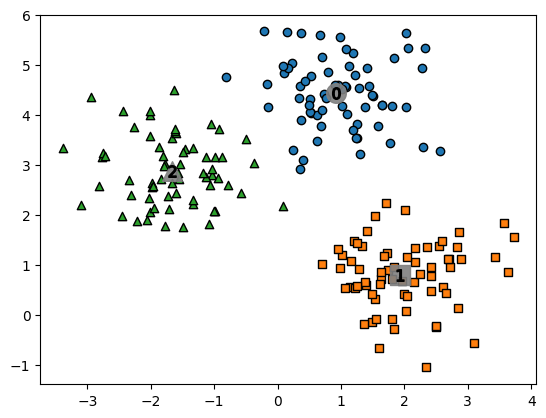

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label'] = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label']==label]
    center_x_y = centers[label]
    #군집별로 다른 마커로 산점도 적용
    plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
    plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [ ]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: count, dtype: int64


평균 이동 장점
1. 데이터 세트의 형태를 특정 형태로 가정, 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화 가능
2. 이상치 영향력 크지 않음
3. 미리 군집의 개수 정할 필요 없음

평균 이동 단점
1. 알고리즘 수행 시간 오래 걸림
2. band-width의 크기에 따른 군집화 영향도 매우 큼

#### **04 GMM(Gaussian Mixture Model)**

**GMM(Gaussian Mixture Model) 소개**

가우시안 분포(GaussianDistribution): 데이터 집합들이 섞여서 생성된 것이라는 가정하에 군집화를 수행하는 방식 - 좌우 대칭형 종(bell) 형태를 가진 연속 확률 변수

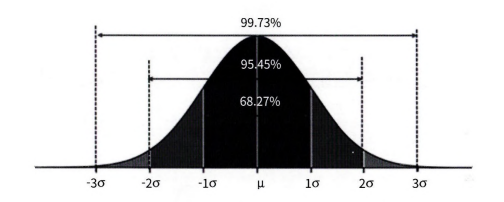



- GMM 군집화 방식: 서로 다른 정규 분포에 기반한 군집화를 수행하는 것
  
  => 모수 추정: EM(Expectation and Maximization)
    
    1. 개별 정규 분포릐 평균과 분산
    2. 각 데이터가 어떤 정규 분포에 해당되는지의 확률

**GMM을 이용한 붓꽃 데이터 세트 군집화**

In [ ]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# 좀 더 편리한 데이터 Modeling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

# 군집화 결과를 irisDF의 'gmm_cluster' 칼럼명으로 저장
irisDF['gmm_cluster'] = gmm_cluster_labels
irisDF['target'] = iris.target

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인.
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       1              50
1       0              45
        2               5
2       2              50
Name: count, dtype: int64


In [ ]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster'] = kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 47
        2                  3
2       2                 36
        0                 14
Name: count, dtype: int64


**GMM과 K-평균의 비교**

KMeans: 원형 범위에서 군집화 수행 => 데이터 세트가 원형 범위 가질수록 KMeans의 군집화 효율 더 높아짐

- clutserobj: 사이킷런 군집 수행 객체
- dataframe: 피처 데이터 세트와 label 값 가진 DataFrame
- label_name: 군집화 결과 시각화 => dataframe 내의 군집화 label 칼럼명, make_blobs() 결과 시각화 => dataframe 내의 target 칼럼명
- iscenter: 사이킷런 Cluster 객체 군집 중심 좌표 공개하면 True

In [ ]:
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

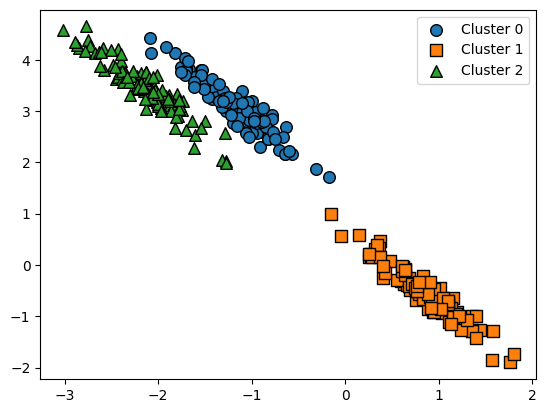

In [ ]:
from sklearn.datasets import make_blobs

# make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std = 0.5를 만듦
X, y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

# 길게 늘어난 타원형의 데이터 세트를 생성하기 위헤 변환함.
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
# feature 데이터 세트와 make_blobs()의 y 결괏값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y
# 생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

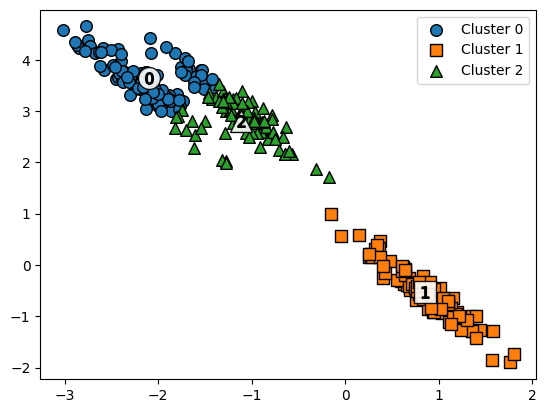

In [ ]:
# 3개의 군집 기반 KMeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscenter=True)

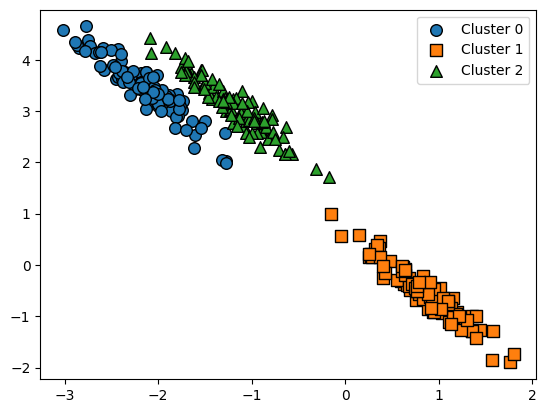

In [ ]:
# 3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label'] = gmm_label

# GaussianMixture는 cluster_centers_ 속성이 없으므로 iscenter를 False로 설정.
visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscenter=False)

In [ ]:
print('### KMeans Clustering ###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering ###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

### KMeans Clustering ###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: count, dtype: int64

### Gaussian Mixture Clustering ###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: count, dtype: int64


- KMeans: 군집 1번만 정확히 매핑됐지만, 나머지 군집의 경우 target 값과 어긋나는 경우가 발생
- GMM: 군집이 target값과 잘 매핑